In [1]:
import warnings
#warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

import statsmodels.api as sm
import statsmodels.formula.api as smf

from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

import plotting
from plotting import PAPER_PRESET, PAPER_FONTSIZE, nice_boxplot, nice_violinplot, mimic_r_boxplot


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
from data_loading import (load_annotated_6k_collection,
                          load_valid_isoform_clones,
                          load_developmental_tissue_expression_remapped)

In [4]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [5]:
np.random.seed(2023)

## functions

In [6]:
def calculate_tau(df):
    array = df.values
    
    ## will return NaN as tau for every row that has any NaNs
    array_max = np.max(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nonan_taus = np.sum(tmp, axis=1) / (array.shape[1])
    
    ## will ignore NaNs and compute on the rest of the values
    array_max = np.nanmax(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nan_taus = np.nansum(tmp, axis=1) / np.count_nonzero(~np.isnan(array), axis=1)
    
    
    return nonan_taus, nan_taus, array_max

In [7]:
rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

## variables

In [8]:
dn_cats_f = "../data/processed/DN_cats_Joung.tsv"

In [9]:
pal = {"ref": sns.color_palette("Set2")[0],
       "ref-v-ref": sns.color_palette("Set2")[0],
       "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1],
       "NA": "lightgray",
       "likely": "darkgray",
       "both": sns.color_palette("Set2")[3]}

## 1. import data

In [10]:
dn_cats = pd.read_table(dn_cats_f)
dn_cats["dn_cat"].fillna("NA", inplace=True)
dn_cats.dn_cat.value_counts()

NA        278
ref       246
DN         93
rewire     74
likely      2
Name: dn_cat, dtype: int64

In [11]:
tfs = load_annotated_6k_collection()

reading from cache


In [12]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()
print(len(df_dev))

reading from cache
1376


## 2. calculate expression ratios (copy-pasted from luke's code in expr_data.ipynb)

In [13]:
metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), 
                            axis=1).mean())
means_dev.head()

,forebrain 04,forebrain 05,forebrain 07,forebrain 08,forebrain 09,forebrain 10,forebrain 11,forebrain 12,forebrain 13,forebrain 16,...,testis 13,testis 16,testis 18,testis 19,testis adolescent,testis adult,testis elderly,testis infant,testis toddler,testis young adult
UID,,,,,,,,,,,,,,,,,,,,,
AEBP2|2/3|05F03 nomatch,1.872479,1.489570,1.081661,0.639046,0.076421,0.871337,8.166145e-01,1.339291,1.596135,1.671030,...,0.676655,0.508048,1.438176,3.241575,0.212430,1.991046,0.000000,1.122607,1.023568,0.446030
AEBP2|3/3|05E07 nomatch,0.399767,0.197733,1.576717,0.216178,0.000000,0.000000,0.000000e+00,0.000000,0.109571,0.251855,...,0.000000,0.324041,0.000000,0.795922,0.000000,0.000000,0.000000,0.791737,0.306721,0.000000
ARNT2|1/6|08C12 ARNT2-201,4.862705,4.959455,6.119775,6.023900,4.897307,5.358537,5.384520e+00,5.985953,5.979885,5.624947,...,4.857934,4.185641,4.572065,3.466014,2.670905,2.519778,2.071869,3.302745,3.687867,2.572277
ARNT2|2/6|09E01 nomatch,0.885055,0.359665,1.515370,0.399531,0.000000,0.160124,1.690750e-01,0.919758,0.545664,0.131184,...,0.235213,0.000000,0.000000,0.000000,0.000000,0.194844,0.000000,0.057435,0.000000,0.025492
ARNT2|3/6|10D11 ARNT2-209,0.000000,0.000000,0.000000,0.000000,1.649287,0.000000,1.101533e-10,0.464061,0.000000,0.000000,...,0.000000,0.209646,0.000000,0.000000,2.628407,0.000000,1.880133,0.000138,0.000000,1.447470


In [14]:
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100
f_dev.head()

,forebrain 04,forebrain 05,forebrain 07,forebrain 08,forebrain 09,forebrain 10,forebrain 11,forebrain 12,forebrain 13,forebrain 16,...,testis 13,testis 16,testis 18,testis 19,testis adolescent,testis adult,testis elderly,testis infant,testis toddler,testis young adult
UID,,,,,,,,,,,,,,,,,,,,,
AEBP2|2/3|05F03 nomatch,8.770825,5.460097,3.748771,3.188589,0.440583,3.743192,4.894554e+00,5.178928,12.198085,13.105607,...,2.563064,1.323679,4.141163,22.014329,1.928627,18.013990,0.000000,4.813526,2.366820,3.044304
AEBP2|3/3|05E07 nomatch,1.128610,0.492277,8.731672,0.803170,0.000000,0.000000,0.000000e+00,0.000000,0.440492,1.167817,...,0.000000,0.678523,0.000000,1.916075,0.000000,0.000000,0.000000,3.721128,0.542803,0.000000
ARNT2|1/6|08C12 ARNT2-201,94.168553,98.542376,96.466911,98.552748,87.660480,98.939268,9.904231e+01,96.300384,96.502246,99.069901,...,98.643781,97.224681,100.000000,100.000000,48.332268,56.638580,43.556409,96.666964,100.000000,58.799880
ARNT2|2/6|09E01 nomatch,3.216348,0.869466,3.533089,0.456195,0.000000,0.290142,2.459982e-01,1.376733,0.794998,0.177557,...,0.580126,0.000000,0.000000,0.000000,0.000000,1.729682,0.000000,0.150583,0.000000,0.174124
ARNT2|3/6|10D11 ARNT2-209,0.000000,0.000000,0.000000,0.000000,11.955511,0.000000,2.650723e-10,0.585737,0.000000,0.000000,...,0.000000,1.131732,0.000000,0.000000,46.973894,0.000000,36.444243,0.003060,0.000000,27.707265


## 3. calculate tissue-specificity

this is currently across all individual samples for genes but not for isos

In [15]:
nonan_taus, nan_taus, array_max = calculate_tau(means_dev)
nan_taus[0:5]

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


array([0.74258093, 0.85959823, 0.45110562, 0.92714449, 0.88590687])

In [16]:
gene_nonan_taus, gene_nan_taus, gene_array_max = calculate_tau(per_gene_dev.drop_duplicates())
gene_nan_taus[0:5]

array([0.72426949, 0.79449918, 0.84426404, 0.87460237, 0.91855192])

In [17]:
gene_taus = pd.DataFrame()
gene_taus["UID"] = per_gene_dev.drop_duplicates().index
gene_taus["tau"] = gene_nan_taus
gene_taus["max_gene_tpm"] = gene_array_max
gene_taus["median_gene_tpm"] = list(per_gene_dev.drop_duplicates().median(axis=1))
gene_taus["gene_name"] = gene_taus["UID"].str.split("|", expand=True)[0]
gene_taus.sample(5)

,UID,tau,max_gene_tpm,median_gene_tpm,gene_name
262,ZNF419|1/4|02H10 ZNF419-201,0.604219,38.882770,15.505100,ZNF419
13,DDIT3|1/2|05B05 DDIT3-204_DDIT3-205,0.992327,822223.027768,217.389173,DDIT3
295,ZNF75A|1/2|11B06 ZNF75A-205_ZNF75A-210,0.782886,310.947167,40.502902,ZNF75A
307,ZSCAN32|1/5|05B06 ZSCAN32-203,0.788543,60.013009,11.664098,ZSCAN32
83,LHX9|1/3|06C10 LHX9-201,0.956154,227.986500,0.398467,LHX9


## 4. join with DN categories

In [18]:
indiv_cols = f_dev.columns
ratios = f_dev.reset_index()
ratios["tau"] = nan_taus

ratios["clone_acc"] = ratios["UID"].str.split(" ", expand=True)[0]
ratios.head()

,UID,forebrain 04,forebrain 05,forebrain 07,forebrain 08,forebrain 09,forebrain 10,forebrain 11,forebrain 12,forebrain 13,...,testis 18,testis 19,testis adolescent,testis adult,testis elderly,testis infant,testis toddler,testis young adult,tau,clone_acc
0,AEBP2|2/3|05F03 nomatch,8.770825,5.460097,3.748771,3.188589,0.440583,3.743192,4.894554e+00,5.178928,12.198085,...,4.141163,22.014329,1.928627,18.013990,0.000000,4.813526,2.366820,3.044304,0.742581,AEBP2|2/3|05F03
1,AEBP2|3/3|05E07 nomatch,1.128610,0.492277,8.731672,0.803170,0.000000,0.000000,0.000000e+00,0.000000,0.440492,...,0.000000,1.916075,0.000000,0.000000,0.000000,3.721128,0.542803,0.000000,0.859598,AEBP2|3/3|05E07
2,ARNT2|1/6|08C12 ARNT2-201,94.168553,98.542376,96.466911,98.552748,87.660480,98.939268,9.904231e+01,96.300384,96.502246,...,100.000000,100.000000,48.332268,56.638580,43.556409,96.666964,100.000000,58.799880,0.451106,ARNT2|1/6|08C12
3,ARNT2|2/6|09E01 nomatch,3.216348,0.869466,3.533089,0.456195,0.000000,0.290142,2.459982e-01,1.376733,0.794998,...,0.000000,0.000000,0.000000,1.729682,0.000000,0.150583,0.000000,0.174124,0.927144,ARNT2|2/6|09E01
4,ARNT2|3/6|10D11 ARNT2-209,0.000000,0.000000,0.000000,0.000000,11.955511,0.000000,2.650723e-10,0.585737,0.000000,...,0.000000,0.000000,46.973894,0.000000,36.444243,0.003060,0.000000,27.707265,0.885907,ARNT2|3/6|10D11


In [19]:
ratios = ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
len(ratios)

692

In [20]:
# also find max tpm
means_dev["max_tpm"] = means_dev.max(axis=1)
tpm = means_dev.reset_index()

tpm["clone_acc"] = tpm["UID"].str.split(" ", expand=True)[0]
ratios = ratios.merge(tpm[["clone_acc", "max_tpm"]], on="clone_acc")
len(ratios)

692

In [21]:
ratios["neglog_diff_pval"] = -np.log10(ratios["Diffusion P-value"])

In [22]:
ratios["num_ov1"] = (ratios[indiv_cols] > 0.1).sum(axis=1)
ratios["num_ov1"].fillna(0, inplace=True)
ratios.sample(5)

,UID,forebrain 04,forebrain 05,forebrain 07,forebrain 08,forebrain 09,forebrain 10,forebrain 11,forebrain 12,forebrain 13,...,seq_aa_tf1p0,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference,orf_len,max_tpm,neglog_diff_pval,num_ov1
12,ATF2|2/6|09E05 ATF2-212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.293696,...,MSDDKPFLCTAPGCGQRFTNEDHLAVHKHKHEMTLKFGPARNDSVI...,TFORF0802-ATF2,0.440660,-0.007084,0.002233,-0.047827,487.0,2.481322,0.355896,35
82,ETV2|2/4|12G10 ETV2-203_ETV2-204,NaN,NaN,7.429919,4.202853,13.975314,0.000000,0.000000,NaN,15.024765,...,MDLWNWDEASPQEVPPGNKLAGLEGAKLGFCFPDLALQGDTPTATA...,TFORF2804-ETV2,0.481737,-0.002583,0.129284,-0.041853,342.0,5.521394,0.317190,53
679,ZSCAN18|2/7|09A01 ZSCAN18-202,0.000000,0.000000,0.076477,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,MLLGSPAGSSSILSDGVYERHMDPLLLPGELASPSQALGAGEIPAP...,TFORF0837-ZSCAN18,0.288882,0.000930,0.000069,-0.006240,374.0,0.134539,0.539279,0
330,RBPJ|3/4|07D11 RBPJ-203,0.137532,0.232532,0.000000,0.000000,0.028736,0.000000,0.219177,2.811694e-10,0.046576,...,MGGCRKFGERPPPKRLTREAMRNYLKERGDQTVLILHAKVAQKSYG...,TFORF3253-RBPJ,0.034329,0.002165,0.000964,-0.008452,485.0,1.296293,1.464333,35
521,ZNF177|2/3|02A03 nomatch,21.396909,9.917496,12.174827,6.542577,2.704483,6.114508,3.757906,7.415250e+00,26.560666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.497651,NaN,110


In [23]:
ratios = ratios.merge(gene_taus[["gene_name", "tau", "max_gene_tpm",
                                 "median_gene_tpm"]], on="gene_name", suffixes=("_iso", "_gene"))
len(ratios)

692

## 5. calculate co-expression

In [24]:
def count_coex(row, thresh):
    tot = 0
    for col in indiv_cols:
        ref_val = row["%s_ref" % col]
        alt_val = row["%s_alt" % col]
        if ref_val > thresh and alt_val > thresh:
            tot += 1
    return tot

In [25]:
ratios_ref = ratios[ratios["dn_cat"] == "ref"]
ratios_alt = ratios[ratios["dn_cat"] != "ref"]

ratios_v = ratios_ref.merge(ratios_alt, on="gene_name", suffixes=("_ref", "_alt"))
ratios_v["num_coex"] = ratios_v.apply(count_coex, thresh=0.1, axis=1)
ratios_v["num_coex"].fillna(0, inplace=True)
ratios_v.sample(5)

,UID_ref,forebrain 04_ref,forebrain 05_ref,forebrain 07_ref,forebrain 08_ref,forebrain 09_ref,forebrain 10_ref,forebrain 11_ref,forebrain 12_ref,forebrain 13_ref,...,RNA Velocity P-value_alt,RNA Velocity difference_alt,orf_len_alt,max_tpm_alt,neglog_diff_pval_alt,num_ov1_alt,tau_gene_alt,max_gene_tpm_alt,median_gene_tpm_alt,num_coex
14,CREB5|1/3|08E11 CREB5-204,0.128629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.212639,-0.006416,369.0,2.273385,0.532530,79,0.837661,35.041741,3.775498,0
58,FLI1|1/4|05A01 FLI1-205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000033,-0.054710,259.0,0.316220,2.347386,0,0.809016,3.423930,0.484757,0
19,CXXC1|2/5|09F10 CXXC1-201,10.220449,13.549166,9.958431,12.457983,9.536997,16.238291,14.145432,27.940324,12.184625,...,0.308474,-0.006967,660.0,5.200685,0.506228,126,0.683629,115.305300,36.252010,126
437,ZNF79|1/3|01H09 ZNF79-201,41.706544,54.445432,57.475743,27.193244,72.083491,57.406980,65.092390,50.919738,58.790007,...,0.495707,-0.001139,474.0,3.723794,1.181216,119,0.882640,39.033376,4.023020,117
188,PAX7|2/4|03C09 PAX7-203,81.220016,87.926616,NaN,92.712787,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.666450,NaN,15,0.959367,37.500165,0.022578,15


In [26]:
# do the null test: randomly sample 2 refs 100 times and do the same thing
null = pd.DataFrame()
for i in range(100):
    ref1 = ratios_ref.sample()
    ref2 = ratios_ref.sample()
    
    ref1["tmp_gene"] = "tmp_gene"
    ref2["tmp_gene"] = "tmp_gene"
    
    mrg = ref1.merge(ref2, on="tmp_gene", suffixes=("_ref", "_alt"))
    mrg["gene_name"] = mrg["gene_name_ref"] + "-v-" + mrg["gene_name_alt"]
    mrg["dn_cat_alt"] = "ref-v-ref"
    mrg["num_coex"] = mrg.apply(count_coex, thresh=0.1, axis=1)
    null = null.append(mrg)

null.sample(5)

,UID_ref,forebrain 04_ref,forebrain 05_ref,forebrain 07_ref,forebrain 08_ref,forebrain 09_ref,forebrain 10_ref,forebrain 11_ref,forebrain 12_ref,forebrain 13_ref,...,RNA Velocity difference_alt,orf_len_alt,max_tpm_alt,neglog_diff_pval_alt,num_ov1_alt,tau_gene_alt,max_gene_tpm_alt,median_gene_tpm_alt,gene_name,num_coex
0,TBX18|3/3|01F09 TBX18-206,0.440049,1.895019,NaN,2.340354,5.004175,3.504336,0.000000,0.000000,8.649689,...,-0.002786,240.0,1.686666,0.855548,8,0.914465,3.390210,0.138392,TBX18-v-DLX4,6
0,ERF|1/2|12B11 ERF-201,51.169937,72.240321,56.435471,67.900893,83.874571,59.269846,52.786525,100.000000,75.666031,...,-0.087225,735.0,5.436089,0.398964,40,0.951110,216.939300,0.117007,ERF-v-RFX4,40
0,IKZF2|2/4|12C01 IKZF2-202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.007023,450.0,4.960285,0.850229,122,0.801800,31.782919,4.981452,IKZF2-v-ZNF277,4
0,ZNF101|1/2|11G06 ZNF101-203,5.311900,12.011222,5.155862,1.197476,5.381788,8.026215,9.634730,0.000066,3.293306,...,-0.001507,505.0,1.123640,1.633618,21,0.982176,1672.408816,5.984050,ZNF101-v-PPARG,19
0,THRB|2/2|07E08 THRB-202_THRB-203_THRB-205_THRB...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,...,-0.000209,254.0,5.033497,2.383697,65,0.940902,78.687380,0.442712,THRB-v-MEOX1,36


In [27]:
ratios_coex = ratios_v[["gene_name", "tf1p0_id_ref", 
                        "tf1p0_id_alt", "dn_cat_alt", 
                        "num_coex", "neglog_diff_pval_ref", 
                        "neglog_diff_pval_alt"]].append(null[["gene_name", "tf1p0_id_ref", 
                                                              "tf1p0_id_alt", "dn_cat_alt", "num_coex",
                                                              "neglog_diff_pval_ref", "neglog_diff_pval_alt"]])
ratios_coex.dn_cat_alt.value_counts()

NA           277
ref-v-ref    100
DN            93
rewire        74
likely         2
Name: dn_cat_alt, dtype: int64

In [28]:
ratios_coex[ratios_coex["gene_name"] == "KLF7"]

,gene_name,tf1p0_id_ref,tf1p0_id_alt,dn_cat_alt,num_coex,neglog_diff_pval_ref,neglog_diff_pval_alt
111,KLF7,KLF7|1/8|01E06,KLF7|3/8|10B10,rewire,106,1.643385,4.619789
112,KLF7,KLF7|1/8|01E06,KLF7|4/8|10E10,DN,121,1.643385,NaN
113,KLF7,KLF7|1/8|01E06,KLF7|5/8|11H02,DN,98,1.643385,1.915983
114,KLF7,KLF7|1/8|01E06,KLF7|6/8|01D06,NA,62,1.643385,NaN
115,KLF7,KLF7|1/8|01E06,KLF7|7/8|10H08,DN,58,1.643385,NaN
116,KLF7,KLF7|1/8|01E06,KLF7|8/8|10D09,NA,100,1.643385,NaN


## 6. make some plots

1.3171474450411794e-09
1.9104410030317664e-06
7.112097570685174e-10
0.26705971762131686
246
74
93
277


/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black", linewidth=0.5)
/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black", linewidth=0.5)
/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2,

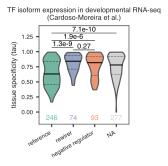

In [29]:
nice_violinplot((2.2, 2.2), ratios, "tau_iso", "dn_cat", pal, ["ref", "rewire", "DN", "NA"], 
                [1.07, 1.19, 1.31, 1.03], -0.05, "", ["reference", "rewirer", "negative regulator", "NA"], 
                "tissue specificity (tau)", False, (-0.2, 1.43), 
                "TF isoform expression in developmental RNA-seq\n(Cardoso-Moreira et al.)", 
                "../figures/DN_DevTau_Violinplot.pdf")

7.510857324248037e-07
0.0006656002634437809
4.196822542638511e-07
0.10673747249238437
246
74
93
277


/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black", linewidth=0.5)
/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black", linewidth=0.5)
/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2,

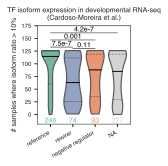

In [30]:
nice_violinplot((2.2, 2.2), ratios, "num_ov1", "dn_cat", pal, ["ref", "rewire", "DN", "NA"], 
             [133, 147, 161, 130], -6, "", ["reference", "rewirer", "negative regulator", "NA"], 
             "# samples where isoform ratio > 10%", False, (-19, 175), 
             "TF isoform expression in developmental RNA-seq\n(Cardoso-Moreira et al.)", 
             "../figures/DN_DevCount_Boxplot.pdf")

In [31]:
ratios["max_tpm_log2"] = np.log2(ratios["max_tpm"]+1)

8.578889236682157e-08
9.564191659303451e-10
8.265501461880058e-17
0.8555644036973855
246
74
93
277


/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black", linewidth=0.5)
/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black", linewidth=0.5)
/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2,

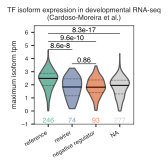

In [32]:
nice_violinplot((2.2, 2.2), ratios, "max_tpm_log2", "dn_cat", pal, ["ref", "rewire", "DN", "NA"], 
             [4.7, 5.3, 5.9, 3.6], -0.5, "", ["reference", "rewirer", "negative regulator", "NA"], 
             "maximum isoform tpm", False, (-1, 6.5), 
             "TF isoform expression in developmental RNA-seq\n(Cardoso-Moreira et al.)", 
             "../figures/DN_DevTpm_Boxplot.pdf")

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


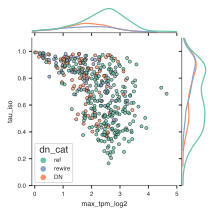

In [33]:
g = sns.jointplot(data=ratios[ratios["dn_cat"].isin(["ref", "rewire", "DN"])], 
                  x="max_tpm_log2", y="tau_iso", hue="dn_cat", palette=pal,
                  height=3, kind="scatter", marginal_kws={"fill": False},
                  joint_kws={"s": 10, "linewidth": 0.5, "edgecolor": "black", "alpha": 0.75},
                  xlim=(-0.1, 5), ylim=(0, 1.1))

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


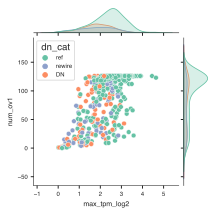

In [34]:
g = sns.jointplot(data=ratios[ratios["dn_cat"].isin(["ref", "rewire", "DN"])], 
                  x="max_tpm_log2", y="num_ov1", hue="dn_cat", palette=pal,
                  height=3, kind="scatter")

In [35]:
ratios.groupby("dn_cat")[["num_ov1", "max_tpm_log2"]].agg(["mean", "median"])

num_ov1        max_tpm_log2          
             mean median         mean    median
dn_cat                                         
DN      76.419355   88.0     1.833928  1.819445
NA      74.989170   85.0     1.822368  1.955415
likely  37.500000   37.5     1.269764  1.269764
ref     91.743902  114.5     2.384855  2.489583
rewire  65.500000   63.0     1.786729  1.830876

In [36]:
ref_expr = ratios_ref.groupby(["tf1p0_id", "gene_name", "dn_cat", "tau_gene", "max_gene_tpm",
                               "median_gene_tpm"])["max_tpm"].agg("max").reset_index()
n_alt = ratios_alt.groupby(["gene_name", "dn_cat"])["tf1p0_id"].agg("count").reset_index()

In [37]:
ref_expr = ref_expr.merge(n_alt[n_alt["dn_cat"] == "DN"][["gene_name", "tf1p0_id"]],
                          on="gene_name", how="left")
ref_expr = ref_expr.merge(n_alt[n_alt["dn_cat"] == "rewire"][["gene_name", "tf1p0_id"]],
                          on="gene_name", how="left")
ref_expr = ref_expr.merge(n_alt[n_alt["dn_cat"] == "NA"][["gene_name", "tf1p0_id"]],
                          on="gene_name", how="left")
ref_expr.columns = ["tf1p0_id", "gene_name", "dn_cat", "tau_gene", "max_gene_tpm", "median_gene_tpm",
                    "max_tpm_ref", "DN", "rewire", "NA"]
ref_expr.fillna(0, inplace=True)
ref_expr["max_tpm_ref"] = np.log2(ref_expr["max_tpm_ref"]+1)
ref_expr["max_gene_tpm"] = np.log2(ref_expr["max_gene_tpm"]+1)
ref_expr["median_gene_tpm"] = np.log2(ref_expr["median_gene_tpm"]+1)
ref_expr.sample(5)

,tf1p0_id,gene_name,dn_cat,tau_gene,max_gene_tpm,median_gene_tpm,max_tpm_ref,DN,rewire,NA
109,POU2F1|2/2|04D01,POU2F1,ref,0.788613,4.286570,1.947803,1.567921,0.0,0.0,1.0
216,ZNF449|1/2|10C10,ZNF449,ref,0.736492,4.535732,2.716410,2.231180,0.0,0.0,1.0
173,ZKSCAN1|1/3|04A11,ZKSCAN1,ref,0.737783,6.662104,4.520743,2.749604,1.0,0.0,0.0
133,SP2|1/5|02B02,SP2,ref,0.663495,5.402630,3.877231,2.448956,0.0,0.0,2.0
212,ZNF419|1/4|02H10,ZNF419,ref,0.604219,5.317694,4.044840,2.113499,0.0,0.0,2.0


In [38]:
to_plot = pd.melt(ref_expr, id_vars=["tf1p0_id", "gene_name", "dn_cat", "tau_gene", "max_tpm_ref",
                                     "median_gene_tpm", "max_gene_tpm"])
to_plot.head()

,tf1p0_id,gene_name,dn_cat,tau_gene,max_tpm_ref,median_gene_tpm,max_gene_tpm,variable,value
0,AEBP2|2/3|05F03,AEBP2,ref,0.724269,2.156453,4.181335,6.265144,DN,0.0
1,ARNT2|1/6|08C12,ARNT2,ref,0.794499,2.948646,4.447401,7.213113,DN,0.0
2,ARNTL2|2/5|12C06,ARNTL2,ref,0.844264,0.917348,1.814680,4.488284,DN,0.0
3,ARNTL|1/2|08H08,ARNTL,ref,0.874602,1.812222,2.542062,6.128229,DN,0.0
4,ATF2|1/6|12H04,ATF2,ref,0.918552,3.181953,5.284428,9.393134,DN,4.0


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


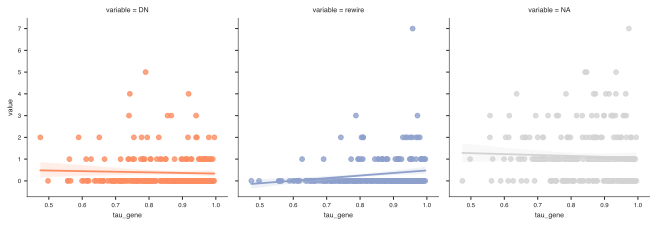

In [39]:
sns.lmplot(data=to_plot, x="tau_gene", y="value", hue="variable", palette=pal, col="variable", height=3)

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


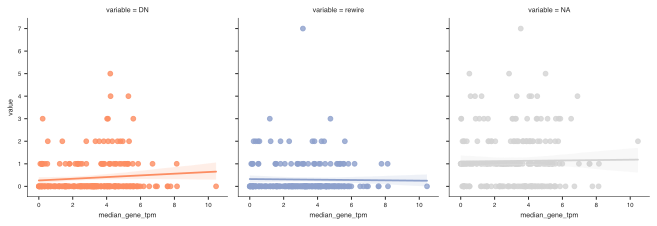

In [40]:
sns.lmplot(data=to_plot, x="median_gene_tpm", y="value", hue="variable", palette=pal, col="variable", height=3)

In [41]:
to_plot["value_bool"] = to_plot["value"] > 0
to_plot.sample(5)

,tf1p0_id,gene_name,dn_cat,tau_gene,max_tpm_ref,median_gene_tpm,max_gene_tpm,variable,value,value_bool
651,TP63|1/3|07F10,TP63,ref,0.941974,1.125847,0.167247,3.367882,NA,2.0,True
399,TGIF1|3/3|02B10,TGIF1,ref,0.985192,3.207249,8.134520,20.262411,rewire,1.0,True
166,ZBTB32|1/3|05D11,ZBTB32,ref,0.988397,0.407491,0.172580,9.851568,DN,0.0,False
709,ZNF451|2/8|06C02,ZNF451,ref,0.742518,2.035238,4.232510,6.166201,NA,0.0,False
566,MEIS1|1/2|09A04,MEIS1,ref,0.849884,2.161671,5.097095,8.484757,NA,0.0,False


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:2989: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 31.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: Us

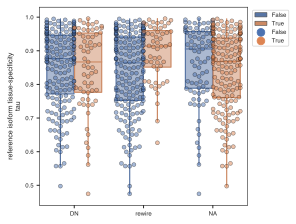

In [42]:
fig = plt.figure(figsize=(4, 3))

ax = sns.boxplot(data=to_plot, x="variable", y="tau_gene", hue="value_bool", 
                 hue_order=[False, True], fliersize=0)

sns.swarmplot(data=to_plot, x="variable", y="tau_gene", hue="value_bool",
              hue_order=[False, True], ax=ax, split=True,
              size=4, edgecolor="black", linewidth=0.5, alpha=0.5)

mimic_r_boxplot(ax)

ax.set_xlabel("")
ax.set_ylabel("reference isoform tissue-specificity\ntau")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), facecolor="white")

#fig.savefig("../figures/Joung_DiffP_Boxplot_QCut.pdf", dpi="figure", bbox_inches="tight")

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:2989: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 37.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 39.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: Us

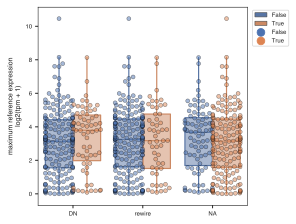

In [43]:
fig = plt.figure(figsize=(4, 3))

ax = sns.boxplot(data=to_plot, x="variable", y="median_gene_tpm", hue="value_bool", 
                 hue_order=[False, True], fliersize=0)

sns.swarmplot(data=to_plot, x="variable", y="median_gene_tpm", hue="value_bool",
              hue_order=[False, True], ax=ax, split=True,
              size=4, edgecolor="black", linewidth=0.5, alpha=0.5)

mimic_r_boxplot(ax)

ax.set_xlabel("")
ax.set_ylabel("maximum reference expression\nlog2(tpm + 1)")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), facecolor="white")

In [44]:
def categorize_gene(row):
    if row.DN > 0 and row.rewire > 0:
        return "both"
    elif row.DN > 0:
        return "DN"
    elif row.rewire > 0:
        return "rewire"
    elif row.NA > 0:
        return "NA"
    
ref_expr["gene_cat"] = ref_expr.apply(categorize_gene, axis=1)
ref_expr.sample(5)

,tf1p0_id,gene_name,dn_cat,tau_gene,max_gene_tpm,median_gene_tpm,max_tpm_ref,DN,rewire,NA,gene_cat
161,WT1|4/6|12A11,WT1,ref,0.861944,8.181042,1.368031,2.974795,0.0,0.0,3.0,NA
193,ZNF250|1/3|05G09,ZNF250,ref,0.759904,5.593258,3.474506,2.445654,0.0,0.0,1.0,NA
126,SMAD3|1/4|06A07,SMAD3,ref,0.794628,6.361816,3.829515,2.694549,2.0,1.0,0.0,both
101,PATZ1|1/4|02C02,PATZ1,ref,0.651009,6.569040,4.807963,2.806871,2.0,0.0,0.0,DN
74,MEIS1|1/2|09A04,MEIS1,ref,0.849884,8.484757,5.097095,2.161671,1.0,0.0,0.0,DN


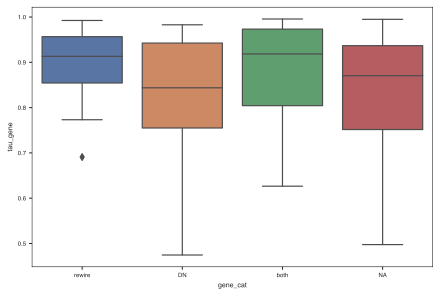

In [45]:
sns.boxplot(data=ref_expr, x="gene_cat", y="tau_gene", order=["rewire", "DN", "both", "NA"])

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 41.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/data/bulyk/kaia/projects/repos/tf_isoforms/src/plotting.py:331: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.

0.014467299638211742
0.7549533746276446
0.009541637032159267
0.04493706581280249
35
46
17
148


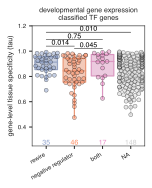

In [48]:
nice_boxplot(ref_expr, "tau_gene", "gene_cat", pal, ["rewire", "DN", "both", "NA"], 
            [1.04, 1.09, 1.15, 1.02], 0.3, "", ["rewire", "negative regulator", "both", "NA"], 
            "gene-level tissue specificity (tau)", False, (0.25, 1.2), 
            "developmental gene expression\nclassified TF genes", 
            "../figures/DN_DevTau_Gene_Boxplot.pdf")

In [47]:
# nice_boxplot(ref_expr, "median_gene_tpm", "gene_cat", pal, ["rewire", "DN", "both", "NA"], 
#             [1.07, 1.19, 1.31, 1.03], -0.05, "", ["rewire", "negative regulator", "both", "NA"], 
#             "median gene-level expression log2(tpm+1)", False, (-1, 1.2), 
#             "TF isoform expression in developmental RNA-seq\n(Cardoso-Moreira et al.)", 
#             "../figures/DN_DevTau_Gene_Boxplot.pdf")